In [1130]:
import os
import pandas as pd
import numpy as np
import bpmn_python.bpmn_diagram_rep as diagram
import bpmn_python.bpmn_diagram_layouter as layouter
import bpmn_python.bpmn_diagram_visualizer as visualizer
import graphviz
from ipywidgets.widgets import Label, Layout, Button, interact, interactive, IntSlider, Checkbox, VBox
from IPython.display import display
import numpy as np

import import_ipynb
import Untitled

1) Set of all tasks and frequencies

In [1131]:
#log_tab = [[0,1,2,3,5,6,8],[0,1,2,4,5,7,8],[0,1,2,1,2,3,5,6,8],[0,0,1,2,4,5,7,8],[0,0,1,2,3,5,6,8],[0,0,1,2,1,2,4,5,7,8],[0,1,2,1,2,1,2,4,5,7,8],[0,1,2,1,2,1,2,3,5,6,8],[0,1,2,1,2,4,5,7,8],[0,0,1,2,1,2,3,5,6,8],[0,1,2,1,2,1,2,1,2,3,5,6,8],[0,0,1,2,1,2,1,2,4,5,7,8],[0,0,0,1,2,4,5,7,8],[0,0,0,1,2,1,2,3,5,6,8],[0,0,0,1,2,3,5,6,8],[0,0,0,0,1,2,4,5,7,8]]
log_tab = [[0,1,2,3],[0,2,1,3],[0,4,3],[0,1,2,4,3],[0,4,2,1,3],[0,3]]
max_task = 0

for row in log_tab:
    if (max(row) > max_task):
        max_task = max(row)
        
#freq = [35,25,9,8,6,3,2,2,2,2,1,1,1,1,1,1]
freq = [9,1,9,1,1,1]

2) Connections matrix

In [1132]:
patternA_list = []
connection = [[0 for x in range(max_task+1)] for x in range(max_task+1)] 
i = -1

for row in log_tab:
    i = i + 1
    for j in range(len(row)-1):
        tupl = (log_tab[i][j], log_tab[i][j+1])
        x = log_tab[i][j]
        y = log_tab[i][j+1]
        connection[x][y] = connection[x][y] + freq[i]
        patternA_list.append(tupl)

3) Creating dependency matrix

In [1133]:
def calculate_dependency(x,y):
    return (connection[x][y] - connection[y][x])/(connection[x][y] + connection[y][x] + 1)

In [1134]:
dependency_matrix = [[0 for x in range(max_task+1)] for x in range(max_task+1)]  

for i in range(len(connection)):
    for j in range(len(connection)):
        dependency_matrix[i][j] = calculate_dependency(i,j)
        
print(dependency_matrix)

[[0.0, 0.9090909090909091, 0.5, 0.5, 0.9090909090909091], [-0.9090909090909091, 0.0, 0.6153846153846154, 0.6666666666666666, 0.0], [-0.5, -0.6153846153846154, 0.0, 0.9, 0.0], [-0.5, -0.6666666666666666, -0.9, 0.0, -0.9090909090909091], [-0.9090909090909091, 0.0, 0.0, 0.9090909090909091, 0.0]]


* Parameters

In [1135]:
dependency = IntSlider(description='Dependency:')
relative_to_best = IntSlider(description='Relative_to_best:')
length_one_loop = IntSlider(description='One_loop:')
length_two_loop = IntSlider(description='Two_loop:')
long_distance = IntSlider(description='Long_loop:')

all_task_connected = Checkbox(description='all_task_connected')
long_distance_dependency = Checkbox(description='long_distance_dependency')
ignore_two_loop = Checkbox(description='ignore_two_loop')

4) Necessary functions

In [1136]:
def simple_connections(dependency_list):
    all_task_con = all_task_connected.value
    rel_to_best = relative_to_best.value/100 #done
    dep = dependency.value/100 #done
    dependency_matrix1 = [[0 for x in range(max_task+1)] for x in range(max_task+1)]   
    
    for i in range(len(connection)):
        for j in range(len(connection)):
            if(dependency_matrix[i][j] > 0):
                tupl = (i,j)
                all_task_list.append(tupl)                
            if(all_task_con == 0):
                if(dependency_matrix[i][j] >= dep):
                    tupl = (i,j)
                    dependency_list.append(tupl)
                    dependency_matrix1[i][j] = dependency_matrix[i][j]
            else:
                dependency_matrix1[i][j] = dependency_matrix[i][j]
                    
    if(all_task_con == 0):
        dependency_list = all_task_list
        
    for row in dependency_matrix1:
        maxi = row.index(max(row))
        threshold = row[maxi]*(1-rel_to_best)
        for elem in row:
            if(elem < threshold):
                x = dependency_matrix1.index(row)
                y = row.index(elem)
                dependency_matrix1[x][y] = 0
                tupl_tmp = (x, y)
                if tupl_tmp in dependency_list:
                    dependency_list.remove(tupl_tmp)

In [1137]:
def oneloop_connections():
    # length_one_loop parameter 
    len_one_loop = length_one_loop.value/100 #done
    shortloop_matrix = [[0 for x in range(max_task+1)] for x in range(max_task+1)]  
    for i in range(len(connection)):
        if(connection[i][i] != 0):
            var = calculate_shortloop(i,i)
            shortloop_matrix[i][i] = var
            if(var >= len_one_loop):
                tupl = (i,i)
                dependency_list.append(tupl)

In [1150]:
def twoloop_connections():
    i_two_loop = ignore_two_loop.value
    len_two_loop = length_two_loop.value/100 #done
    twoloop = [[0 for x in range(max_task+1)] for x in range(max_task+1)]
    j = -1
    
    for row in log_tab:
        j = j + 1
        for i in range(len(row)-2):
            first = row[i]
            second = row[i+1]
            third = row[i+2]
            if(first == third):
                twoloop[first][second] = twoloop[first][second] + freq[j]
                
    loop_list = []

    for i in range(max_task+1):
        for j in range(max_task+1):
            var = (twoloop[i][j]+twoloop[j][i])/(twoloop[i][j]+twoloop[j][i] + 1)
            if (i_two_loop == 0 and var >= len_two_loop and i!=j):
                tupl = (i,j)
                loop_list.append(tupl) 
    return loop_list

In [1151]:
def create_Tinput():
    Tinput = []
    for i in range(len(log_tab)):
        if log_tab[i][0] not in Tinput:
            Tinput.append(log_tab[i][0])
    return Tinput

In [1152]:
def create_Toutput():
    Toutput = []
    for i in range(len(log_tab)):
        if log_tab[i][len(log_tab[i])-1] not in Toutput:
            Toutput.append(log_tab[i][len(log_tab[i])-1])
    return Toutput

In [1153]:
def create_patternB(footprint):
    patternB_list = []
    for i in range(len(footprint)):
        tab_tmp = []
        for j in range(len(footprint)):
            if(footprint[i][j] == 1):
                tab_tmp.append(j)
        if(len(tab_tmp) > 1):
            tab_tmp.append(i)
            tab_tmp = np.asarray(tab_tmp)
            patternB_list.append(tab_tmp)    
    
    for i in range(len(patternB_list)):
        tupl = (patternB_list[i][0], patternB_list[i][1])
        tupl2 = (patternB_list[i][0], patternB_list[i][2])
        tupl3 = (patternB_list[i][2], patternB_list[i][0])
        tupl4 = (patternB_list[i][2], patternB_list[i][1])
        tab = [tupl, tupl2, tupl3, tupl4]
        for elem in tab:
            if elem in dependency_list:
                dependency_list.remove(elem)
    
    return patternB_list

In [1154]:
def create_patternC(footprint):
    patternC_list = []
    for i in range(len(footprint)):
        tab_tmp2 = []
        for j in range(len(footprint)):
            if(footprint[j][i] == 1):
                tab_tmp2.append(j)
        if(len(tab_tmp2) > 1):
            tab_tmp2.append(i)
            tab_tmp2 = np.asarray(tab_tmp2)
            patternC_list.append(tab_tmp2) 
            
    for i in range(len(patternC_list)):
        tupl = (patternC_list[i][0], patternC_list[i][2])
        tupl2 = (patternC_list[i][1], patternC_list[i][2])
        tupl3 = (patternC_list[i][2], patternC_list[i][0])
        tupl4 = (patternC_list[i][2], patternC_list[i][1])
        tab = [tupl, tupl2, tupl3, tupl4]
        for elem in tab:
            if elem in dependency_list:
                dependency_list.remove(elem) 
    
    return patternC_list

In [1155]:
def checkWhatIsConnected(Tinput, patternB_list, patternC_list, Toutput):
    
    checkWhatIsConnectedList = {}
    check_list = []
    for elem in dependency_list:
        check_list.append(elem)  

    for elem in patternB_list:
        tupl = (elem[2], elem[0])
        tupl2 = (elem[2], elem[1])
        check_list.append(tupl)
        check_list.append(tupl2)

    for elem in patternC_list:
        tupl = (elem[0], elem[2])
        tupl2 = (elem[1], elem[2])
        check_list.append(tupl)
        check_list.append(tupl2)
        
    for i in range(max_task+1):
        checkWhatIsConnectedList[i] = False
    
    for i in range(max_task+1):
        taken_begin = False
        taken_end = False
        for elem in check_list:
            if(i == Tinput[0]):
                if(elem[0] == i):
                    taken_begin = True
                taken_end = True
            elif(i == Toutput[0]):
                if(elem[1] == i):
                    taken_end = True
                taken_begin = True
            else:
                if(elem[0] == i):
                    taken_begin = True
                if(elem[1] == i):
                    taken_end = True
        if(taken_begin == False):
            for elem in all_task_list:
                if(elem[0] == i):
                    taken_begin = True 
                    dependency_list.append(elem)
                    check_list.append(elem)
                    break;
        if(taken_end == False):
            for elem in all_task_list:
                if(elem[1] == i):
                    taken_end = True 
                    dependency_list.append(elem)
                    check_list.append(elem)
                    break;
        if(taken_begin == True and taken_end == True):
            checkWhatIsConnectedList[i] = True
    
    #print(all_task_list)
    #for elem in all_task_list:
    #    if(elem not in check_list):
    #        dependency_list.append(elem)

In [1171]:
dependency_list = []
all_task_list = []  

def calculate_shortloop(x,y):
    return connection[x][y]/(connection[x][y] + 1)

def calculate_twoloop(x,y, twoloop):
    return (twoloop[x][y]+twoloop[y][x])/(twoloop[x][y]+twoloop[y][x] + 1)

def generate_model(b):  
       
    simple_connections(dependency_list)
    oneloop_connections()
    loop_list = twoloop_connections()
                    
    Tinput = create_Tinput() 
    Toutput = create_Toutput()
    
    # Matrix from AlphaMiner
    footprint = np.zeros((max_task+1, max_task+1))
    for i in dependency_list:
        x = i[0]
        y = i[1]
        footprint[x][y] = 1

    for i in loop_list:
        x = i[0]
        y = i[1]
        footprint[x][y] = footprint[x][y] + 2       
    footprint[1][2] = 1  #TODO: tu jakis problem       
        
    # 7) Creating a model
    patternB_list = create_patternB(footprint)
    patternC_list = create_patternC(footprint)
    
    for i in range(len(footprint)):
        for j in range(len(footprint)):
            if(footprint[i][j] >= 3):
                dependency_list.remove((i, j))
    
    tab_of_tasks = []
    for elem in range(max_task):
        tab_of_tasks.append(elem)
  
    checkWhatIsConnected(Tinput, patternB_list, patternC_list, Toutput)
    dependency_list.extend(loop_list)
    create_graph(Tinput, patternB_list, patternC_list, dependency_list, Toutput)

In [1172]:
def create_graph(Tinput, patternB_list, patternC_list, dependency_list, Toutput):
    # Graph   
    bpmn_graph = diagram.BpmnDiagramGraph()
    bpmn_graph.create_new_diagram_graph(diagram_name="diagram1")
    process_id = bpmn_graph.add_process_to_diagram()
    
    tab = {}
    tab_help=[]
    
    #beginning
    [start_id, _] = bpmn_graph.add_start_event_to_diagram(process_id, start_event_name="start_event")
    if(len(Tinput) > 1):  
        [exclusive_gate_id, _] = bpmn_graph.add_exclusive_gateway_to_diagram(process_id, gateway_name="X")
        for elem in Tinput:
            if elem not in tab_help:
                tab[elem] = bpmn_graph.add_task_to_diagram(process_id, task_name=elem)
                tab_help.append(elem)
        bpmn_graph.add_sequence_flow_to_diagram(process_id, start_id, exclusive_gate_id)
        bpmn_graph.add_sequence_flow_to_diagram(process_id, exclusive_gate_id, tab[Tinput[0]][0])
        bpmn_graph.add_sequence_flow_to_diagram(process_id, exclusive_gate_id, tab[Tinput[1]][0])
    else:
        tab[Tinput[0]] = bpmn_graph.add_task_to_diagram(process_id, task_name=Tinput[0])
        bpmn_graph.add_sequence_flow_to_diagram(process_id, start_id, tab[Tinput[0]][0])
        tab_help.append(Tinput[0])       
    
    # connections a#(b,c)
    for elem in patternB_list:
        [exclusive_gate_id, _] = bpmn_graph.add_exclusive_gateway_to_diagram(process_id, gateway_name="X")
        for val in elem:
            if(val not in tab_help):
                tab[val] = bpmn_graph.add_task_to_diagram(process_id, task_name=val)
                tab_help.append(val)       
        bpmn_graph.add_sequence_flow_to_diagram(process_id, tab[elem[2]][0], exclusive_gate_id)
        #if(elem[0] == elem[1]):
        bpmn_graph.add_sequence_flow_to_diagram(process_id, exclusive_gate_id, tab[elem[0]][0])
        bpmn_graph.add_sequence_flow_to_diagram(process_id, exclusive_gate_id, tab[elem[1]][0]) 

    # connections (b,c)#d
    for elem in patternC_list:
        [exclusive_gate_id, _] = bpmn_graph.add_exclusive_gateway_to_diagram(process_id, gateway_name="X")
        for val in elem:
            if(val not in tab_help):
                tab[val] = bpmn_graph.add_task_to_diagram(process_id, task_name=val)
                tab_help.append(val)
        bpmn_graph.add_sequence_flow_to_diagram(process_id, tab[elem[0]][0], exclusive_gate_id)
        bpmn_graph.add_sequence_flow_to_diagram(process_id, tab[elem[1]][0], exclusive_gate_id)
        bpmn_graph.add_sequence_flow_to_diagram(process_id, exclusive_gate_id, tab[elem[2]][0])    

    # tasks
    for elem in dependency_list:
        if(elem[0] not in tab_help):
            tab[elem[0]] = bpmn_graph.add_task_to_diagram(process_id, task_name=elem[0])
            tab_help.append(elem[0])
        if(elem[1] not in tab_help):
            tab[elem[1]] = bpmn_graph.add_task_to_diagram(process_id, task_name=elem[1])
            tab_help.append(elem[1])
        bpmn_graph.add_sequence_flow_to_diagram(process_id, tab[elem[0]][0], tab[elem[1]][0])     

    # end
    if(len(Toutput) > 1):
        [exclusive_gate_id, _] = bpmn_graph.add_exclusive_gateway_to_diagram(process_id, gateway_name="X")
        for elem in Toutput:
            if elem not in tab_help: 
                tab[elem] = bpmn_graph.add_task_to_diagram(process_id, task_name=elem)
                tab_help.append(elem)
        bpmn_graph.add_sequence_flow_to_diagram(process_id, tab[Toutput[0]][0], exclusive_gate_id)
        bpmn_graph.add_sequence_flow_to_diagram(process_id, tab[Toutput[1]][0], exclusive_gate_id)
        [end_id, _] = bpmn_graph.add_end_event_to_diagram(process_id, end_event_name="end_event")
        bpmn_graph.add_sequence_flow_to_diagram(process_id, exclusive_gate_id, end_id)
    else:
        if Toutput[0] not in tab_help:
            tab[Toutput[0]] = bpmn_graph.add_task_to_diagram(process_id, task_name=Toutput[0])
        [end_id, _] = bpmn_graph.add_end_event_to_diagram(process_id, end_event_name="end_event")
        bpmn_graph.add_sequence_flow_to_diagram(process_id, tab[Toutput[0]][0], end_id)      
        
    visualizer.bpmn_diagram_to_png(bpmn_graph, file_name = 'Model5')
    print("Model generated.")
    
    from IPython.display import Image
    photo = Image("C:/Users/Lenovo/Desktop/Magisterka/AlphaMiner/AlphaMiner/Model5.png")
    display(photo)
    print(Tinput)
    print(patternB_list)
    print(patternC_list)
    print(dependency_list)
    print(Toutput)

Button(description='Generate model', style=ButtonStyle())

Model generated.


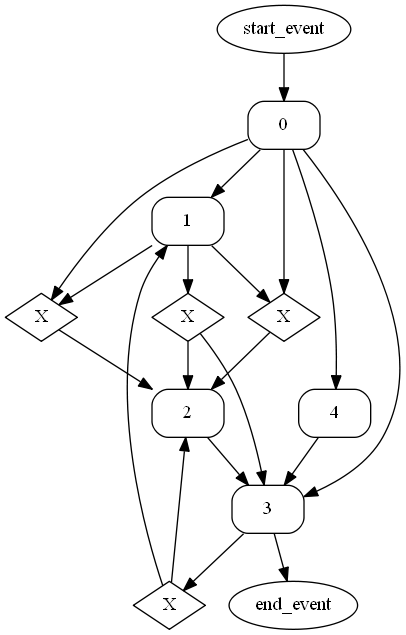

[0]
[array([1, 2, 3, 4, 0]), array([2, 3, 1])]
[array([0, 1, 2]), array([0, 1, 2, 4, 3])]
[(0, 1), (0, 3), (0, 4), (4, 3), (2, 3)]
[3]


In [1173]:
box = VBox(children=(dependency, relative_to_best, length_one_loop, length_two_loop), layout=Layout(border='solid 2px gray', width='500px'))
box2 = VBox(children=(all_task_connected, ignore_two_loop), layout=Layout(border='solid 2px gray', width='500px'))
button = Button(description = "Generate model")
button.on_click(generate_model)

display(box)
display(box2)
display(button)